In [165]:
from numpy import array
import pandas as pd
import keras
import numpy as np
from datetime import datetime
from numpy import asarray
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib as plt
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import KFold
import random
from sklearn.utils import shuffle
from matplotlib import pyplot as plt
import tensorflow as tf
import pickle
import csv
from keras.models import save_model, load_model

In [176]:
icp_monthly = pd.read_csv('IPC_data_train.csv',sep=';')
icp_monthly=icp_monthly.groupby('Date').mean('IPC').reset_index()
random.seed(1)
icp_monthly['Date'] = pd.to_datetime(icp_monthly['Date'])
icp_monthly = icp_monthly.iloc[0:icp_monthly.shape[0]]

In [179]:
icp_monthly[['Date','IPC']].head()

,Date,IPC
0,2020-06-01,1.643548
1,2020-07-01,-15.332382
2,2020-08-01,6.993673
3,2020-09-01,-0.147431
4,2020-10-01,0.240681


In [194]:
n_steps_in = 3  #количество учитываемых лагов
n_steps_out = 1 #количество периодов для прогноза

In [195]:
scaler = MinMaxScaler()
scaled_CPI = asarray(icp_monthly['IPC']).reshape(-1, 1)
scaled_CPI = scaler.fit_transform(scaled_CPI)


In [196]:
p=4 #лагов

In [197]:
out_of_sample_forecast_input = scaled_CPI[21:, 0]
scaled_CPI = scaled_CPI[:21, 0]

In [198]:
def split_sequences(sequence, n_steps_in, n_steps_out):
        X, y = list(), list()
        for i in range(len(sequence) - (n_steps_in + n_steps_out)):
            append_X = []
            append_y = []
            for j in range(n_steps_in):
                append_X.append(sequence[i + j])
            for k in range(n_steps_out):
                append_y.append(sequence[i + n_steps_in + k + 1])

            X.append(append_X)
            y.append(append_y)

        return np.array(X), np.array(y)


In [199]:
X, y = split_sequences(scaled_CPI, n_steps_in=n_steps_in, n_steps_out=n_steps_out)

In [200]:
random.seed(1)
X_test = []
y_test = []

for i in range(5):
    index = random.randint(0, 6 - i)
    X_test.append(X[index])
    y_test.append(y[index])
    X = np.delete(X, index, 0)
    y = np.delete(y, index, 0)

X_test = asarray(X_test)
y_test = asarray(y_test)

X, y = shuffle(X, y, random_state=0)


In [201]:
kf_X = KFold(n_splits=2)
partitions_X_train = []
partitions_X_valid = []
for train_index, validation_index in kf_X.split(X):
    set_train_X = []
    set_valid_X = []
    for j in train_index:
        set_train_X.append(X[j])
    partitions_X_train.append(asarray(set_train_X))
    for k in validation_index:
        set_valid_X.append(X[k])
    partitions_X_valid.append(asarray(set_valid_X))

kf_y = KFold(n_splits=2)
partitions_y_train = []
partitions_y_valid = []
for train_index, validation_index in kf_y.split(y):
    set_train_y = []
    set_valid_y = []
    for j in train_index:
        set_train_y.append(y[j])
    partitions_y_train.append(asarray(set_train_y))
    for k in validation_index:
        set_valid_y.append(y[k])
    partitions_y_valid.append(asarray(set_valid_y))

partitions_X_train = asarray(partitions_X_train)
partitions_y_train = asarray(partitions_y_train)
partitions_X_valid = asarray(partitions_X_valid)
partitions_y_valid = asarray(partitions_y_valid)
Set_of_average_cross_valid_MSE = []
X= X.reshape(X.shape[0], X.shape[1], 1)
y = y.reshape(y.shape[0], y.shape[1], 1)


In [202]:
model = Sequential()
    # Составные слои LSTM
model.add(LSTM(75, activation='sigmoid', return_sequences=True, input_shape=(n_steps_in, 1))) ##реккурентный слой
model.add(LSTM(75, activation='sigmoid', return_sequences=False)) 
model.add(Dropout(0.2)) #борьба с переобучением
model.add(Dense(n_steps_out)) 
model.compile(loss='mae', optimizer='adam',metrics=['mae'])
history = model.fit(X, y,batch_size=2,epochs=1000,verbose=1)
model.save('my_model.h5')


Epoch 1/1000
6/6 [==============================] - 1s 5ms/step - loss: 0.2423 - mae: 0.2423
Epoch 2/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.2827 - mae: 0.2827
Epoch 3/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.2104 - mae: 0.2104
Epoch 4/1000
6/6 [==============================] - 0s 5ms/step - loss: 0.2034 - mae: 0.2034
Epoch 5/1000
6/6 [==============================] - 0s 5ms/step - loss: 0.1853 - mae: 0.1853
Epoch 6/1000
6/6 [==============================] - 0s 5ms/step - loss: 0.1828 - mae: 0.1828
Epoch 7/1000
6/6 [==============================] - 0s 5ms/step - loss: 0.2546 - mae: 0.2546
Epoch 8/1000
6/6 [==============================] - 0s 5ms/step - loss: 0.1551 - mae: 0.1551
Epoch 9/1000
6/6 [==============================] - 0s 5ms/step - loss: 0.0851 - mae: 0.0851
Epoch 10/1000
6/6 [==============================] - 0s 5ms/step - loss: 0.2377 - mae: 0.2377
Epoch 11/1000
6/6 [==============================] - 0s 5ms/step - lo

In [221]:
model.save('my_model.h5')

In [218]:
out_of_sample_forecast_input = asarray(out_of_sample_forecast_input).reshape(1, n_steps_in)
out_of_sample_forecast = model.predict(out_of_sample_forecast_input, verbose=0)

list_forecast= scaler.inverse_transform(out_of_sample_forecast).tolist()
print(list_forecast[0])
aList= [ele for ele in list_forecast[0]]

[3.6321449279785156]


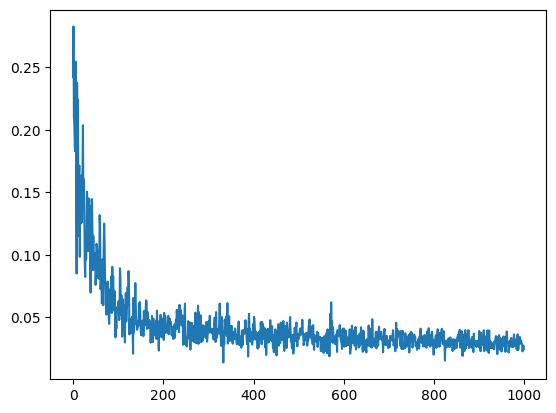

In [205]:
plt.plot(history.history['mae'])
plt.show()

In [206]:
model = load_model('my_model.h5')

In [214]:
df_trainn=pd.read_excel('Y_train.xlsx')

In [215]:
df_trainn.count()

ICP     24
Date    24
dtype: int64

In [216]:
scaler = MinMaxScaler()
scaled_CPI = asarray(icp_monthly['IPC']).reshape(-1, 1)
scaled_CPI = scaler.fit_transform(scaled_CPI)
out_of_sample_forecast_input = scaled_CPI[21:, 0]
scaled_CPI = scaled_CPI[:21, 0]
X, y = split_sequences(scaled_CPI, n_steps_in=n_steps_in, n_steps_out=n_steps_out)

In [217]:
history = model.fit(X, y,batch_size=2,epochs=1000,verbose=1)

Epoch 1/1000
9/9 [==============================] - 1s 6ms/step - loss: 0.0401 - mae: 0.0401
Epoch 2/1000
9/9 [==============================] - 0s 5ms/step - loss: 0.0427 - mae: 0.0427
Epoch 3/1000
9/9 [==============================] - 0s 5ms/step - loss: 0.0398 - mae: 0.0398
Epoch 4/1000
9/9 [==============================] - 0s 5ms/step - loss: 0.0451 - mae: 0.0451
Epoch 5/1000
9/9 [==============================] - 0s 5ms/step - loss: 0.0390 - mae: 0.0390
Epoch 6/1000
9/9 [==============================] - 0s 5ms/step - loss: 0.0436 - mae: 0.0436
Epoch 7/1000
9/9 [==============================] - 0s 5ms/step - loss: 0.0377 - mae: 0.0377
Epoch 8/1000
9/9 [==============================] - 0s 5ms/step - loss: 0.0419 - mae: 0.0419
Epoch 9/1000
9/9 [==============================] - 0s 5ms/step - loss: 0.0405 - mae: 0.0405
Epoch 10/1000
9/9 [==============================] - 0s 5ms/step - loss: 0.0475 - mae: 0.0475
Epoch 11/1000
9/9 [==============================] - 0s 4ms/step - lo